# **Mid-Bootcamp Project - Classification**

## **Introduction**

- **The aim of this project is to create a machine learning algorithm that can correctly identify customers who accepted or rejected a credit card offer from a bank.**
- **The dataset is highly imbalanced with around 94% of rows belonging to one of the two classes.**
- **I will be using logistic regression, KNN & random forest algorithms with a combination of different sampling techniques to try and deal with the data imbalance.**
- **Due to the data imbalance I will focus on trying to build a model which can correctly identify rows from the minority class (around 6% of the total dataset).**

In [1]:
# import relevant libraries

import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import getpass 
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")


## **Importing Data from MYSQL**

- First step: importing the data from MYSQL - for this we need to set up a connection to the database and then just simply pull it using an SQL query

In [2]:
# set up connection to MYSQL

password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/credit_card_classification'
engine = create_engine(connection_string)

In [3]:
# pull data from mysql database into pandas dataframe

query = '''SELECT *
           FROM credit_card_data
           ;'''

data = pd.read_sql_query(query, engine)
data

Customer_Number Offer_Accepted     Reward Mailer_Type Income_Level  \
0                    1             No  Air Miles      Letter         High   
1                    2             No  Air Miles      Letter       Medium   
2                    3             No  Air Miles    Postcard         High   
3                    4             No  Air Miles      Letter       Medium   
4                    5             No  Air Miles      Letter       Medium   
...                ...            ...        ...         ...          ...   
17971            17996             No  Cash Back      Letter         High   
17972            17997             No  Cash Back      Letter         High   
17973            17998             No  Cash Back      Letter         High   
17974            17999             No  Cash Back      Letter       Medium   
17975            18000             No  Cash Back      Letter          Low   

       No_Bank_Accounts_Open Overdraft_Protection Credit_Rating  \
0                          1                   No          High   
1                          1                   No        Medium   
2                          2                   No        Medium   
3                          2                   No          High   
4                          1                   No        Medium   
...                      ...                  ...           ...   
17971                      1                   No           Low   
17972                      1                   No           Low   
17973                      1                   No           Low   
17974                      1                   No        Medium   
17975                      2                   No        Medium   

       No_Credit_Cards_Held  No_Homes_Owned  Household_Size Own_Your_Home  \
0                         2               1               4            No   
1                         2               2               5           Yes   
2                         2               1               2           Yes   
3                         1               1               4            No   
4                         2               1               6           Yes   
...                     ...             ...             ...           ...   
17971                     1               1               5           Yes   
17972                     3               1               3           Yes   
17973                     2               1               4            No   
17974                     4               2               2           Yes   
17975                     2               1               3            No   

       Average_Balance  Q1_Balance  Q2_Balance  Q3_Balance  
0              1160.75        1669         877        1095  
1               147.25          39         106          78  
2               276.50         367         352         145  
3              1219.00        1578        1760        1119  
4              1211.00        2140        1357         982  
...                ...         ...         ...         ...  
17971           167.50         136          65          71  
17972           850.50         984         940         943  
17973          1087.25         918         767        1170  
17974          1022.25         626         983         865  
17975          1056.00         265        1378        1978  

[17976 rows x 16 columns]

## **Exploratory Data Analysis & Data Cleaning**

- Lets take a look at the data to see what we are dealing with before modelling

### **Numericals**

In [4]:
data['Customer_Number'].nunique()

17976

In [5]:
# customer number can be used as the index as all of the values are unique

data = data.set_index('Customer_Number')

In [6]:
# function to standardise column names

def header_cleaner(df):
    for col in df.columns:
        df.columns = df.columns.str.replace(" ","_").str.lower()
        df.columns = df.columns.str.replace("#",'number')
    return df

In [7]:
header_cleaner(data)

offer_accepted     reward mailer_type income_level  \
Customer_Number                                                      
1                           No  Air Miles      Letter         High   
2                           No  Air Miles      Letter       Medium   
3                           No  Air Miles    Postcard         High   
4                           No  Air Miles      Letter       Medium   
5                           No  Air Miles      Letter       Medium   
...                        ...        ...         ...          ...   
17996                       No  Cash Back      Letter         High   
17997                       No  Cash Back      Letter         High   
17998                       No  Cash Back      Letter         High   
17999                       No  Cash Back      Letter       Medium   
18000                       No  Cash Back      Letter          Low   

                 no_bank_accounts_open overdraft_protection credit_rating  \
Customer_Number                                                             
1                                    1                   No          High   
2                                    1                   No        Medium   
3                                    2                   No        Medium   
4                                    2                   No          High   
5                                    1                   No        Medium   
...                                ...                  ...           ...   
17996                                1                   No           Low   
17997                                1                   No           Low   
17998                                1                   No           Low   
17999                                1                   No        Medium   
18000                                2                   No        Medium   

                 no_credit_cards_held  no_homes_owned  household_size  \
Customer_Number                                                         
1                                   2               1               4   
2                                   2               2               5   
3                                   2               1               2   
4                                   1               1               4   
5                                   2               1               6   
...                               ...             ...             ...   
17996                               1               1               5   
17997                               3               1               3   
17998                               2               1               4   
17999                               4               2               2   
18000                               2               1               3   

                own_your_home  average_balance  q1_balance  q2_balance  \
Customer_Number                                                          
1                          No          1160.75        1669         877   
2                         Yes           147.25          39         106   
3                         Yes           276.50         367         352   
4                          No          1219.00        1578        1760   
5                         Yes          1211.00        2140        1357   
...                       ...              ...         ...         ...   
17996                     Yes           167.50         136          65   
17997                     Yes           850.50         984         940   
17998                      No          1087.25         918         767   
17999                     Yes          1022.25         626         983   
18000                      No          1056.00         265        1378   

                 q3_balance  
Customer_Number              
1                      1095  
2                        78  
3                       145  
4                      1119  
5         

In [8]:
data.shape, data.dtypes


((17976, 15),
 offer_accepted            object
 reward                    object
 mailer_type               object
 income_level              object
 no_bank_accounts_open      int64
 overdraft_protection      object
 credit_rating             object
 no_credit_cards_held       int64
 no_homes_owned             int64
 household_size             int64
 own_your_home             object
 average_balance          float64
 q1_balance                 int64
 q2_balance                 int64
 q3_balance                 int64
 dtype: object)

In [9]:
# check central tendencies and spread of data
# we can see that number of bank accounts, no of credit cards held & no of homes owned do not have much variance
# household size and the balance columns have some outliers at the higher end
# for the logistic regression model we will need to deal with outliers before modelling

summary = data.describe().T 
summary['iqr'] = summary['75%']-summary['25%'] 
summary = summary.apply(round)
summary

count    mean    std   min    25%     50%     75%  \
no_bank_accounts_open  17976.0     1.0    0.0   1.0    1.0     1.0     1.0   
no_credit_cards_held   17976.0     2.0    1.0   1.0    1.0     2.0     2.0   
no_homes_owned         17976.0     1.0    0.0   1.0    1.0     1.0     1.0   
household_size         17976.0     3.0    1.0   1.0    3.0     3.0     4.0   
average_balance        17976.0   941.0  350.0  48.0  788.0  1007.0  1153.0   
q1_balance             17976.0   910.0  620.0   0.0  393.0   772.0  1521.0   
q2_balance             17976.0   999.0  457.0   0.0  663.0  1032.0  1342.0   
q3_balance             17976.0  1042.0  553.0   0.0  633.0   946.0  1463.0   

                          max     iqr  
no_bank_accounts_open     3.0     0.0  
no_credit_cards_held      4.0     1.0  
no_homes_owned            3.0     0.0  
household_size            9.0     1.0  
average_balance        3366.0   366.0  
q1_balance             3450.0  1128.0  
q2_balance             3421.0   679.0  
q3_balance             3823.0   830.0

In [10]:
# check for nulls - luckily there are none here :)

data.isna().sum()

offer_accepted           0
reward                   0
mailer_type              0
income_level             0
no_bank_accounts_open    0
overdraft_protection     0
credit_rating            0
no_credit_cards_held     0
no_homes_owned           0
household_size           0
own_your_home            0
average_balance          0
q1_balance               0
q2_balance               0
q3_balance               0
dtype: int64

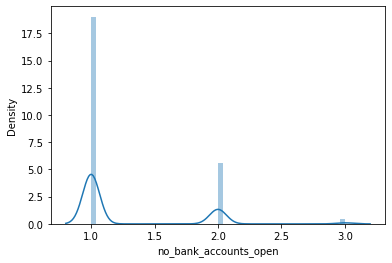

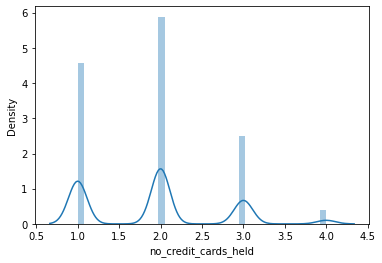

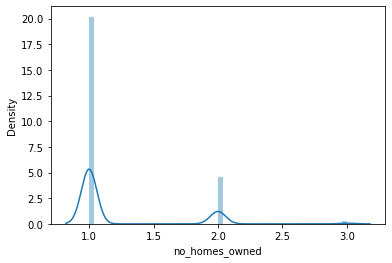

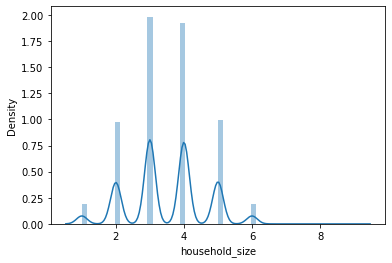

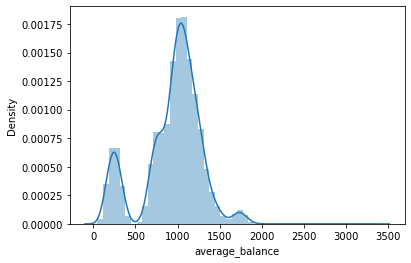

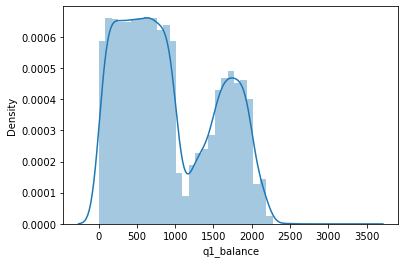

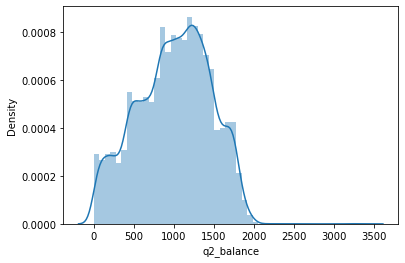

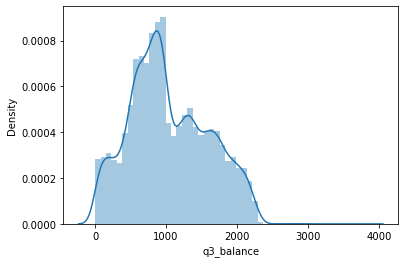

In [11]:
# check distribution of numerical columns 
# i won't do any transformations here because will deal with outliers later which should make the distribution of avg_balance more normal. the other variables are too crammed in together for a transformation to work I think

for col in data.select_dtypes(np.number):
    sns.distplot(data[col])
    plt.show()

In [12]:
# check counts of categorical variables per column
# in general the different categorical variables are evenly distributed except our target variable offer_accepted and overdraft_protection and own_your_home
# the target variable is very unevenly distributed

for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

No     16955
Yes     1021
Name: offer_accepted, dtype: int64 

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64 

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64 

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64 

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

Yes    11636
No      6340
Name: own_your_home, dtype: int64 



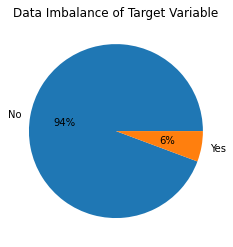

In [13]:
# here is a look at just the target variable to show the imbalance

fig, ax = plt.subplots()
ax.pie(data['offer_accepted'].value_counts(), autopct='%.0f%%',labels=['No','Yes'])
plt.title('Data Imbalance of Target Variable')
plt.show()

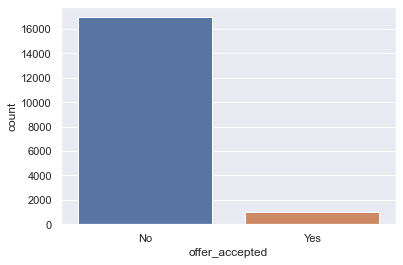

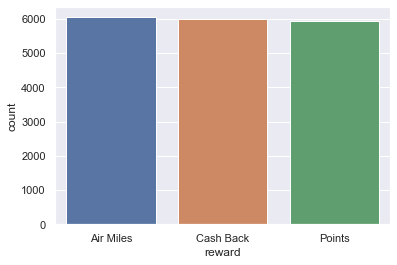

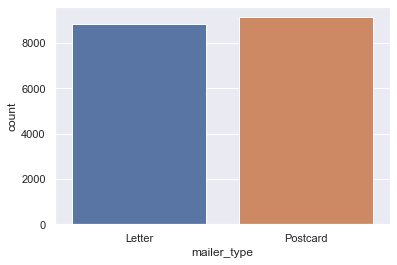

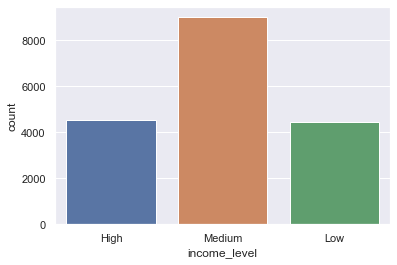

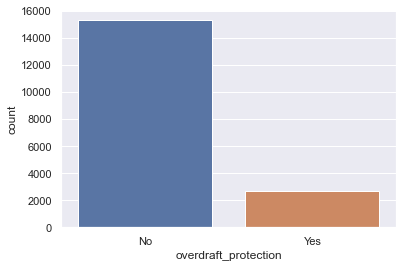

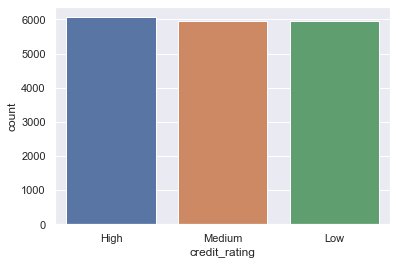

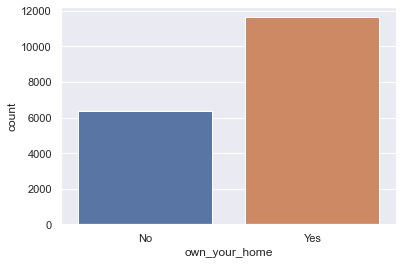

In [14]:
# visualise distrubtion of categorical variables with countplots

sns.set_theme(style="darkgrid")


for col in data.select_dtypes(include='object'):
    sns.countplot(data[col])
    plt.show()
   

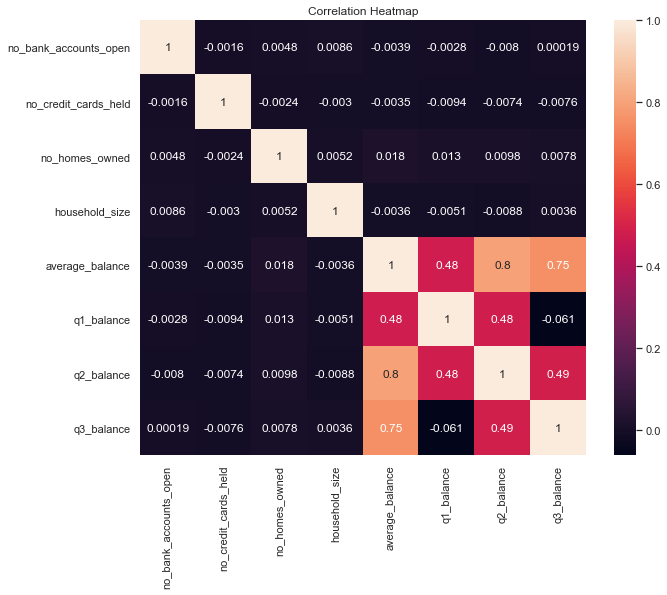

In [15]:
# check correlation of data - if two variables have high multicollinearity, one can be dropped
# based on this I would drop Q1, Q2 & Q3 balance as they have high multicollinearity and we have the average balance anyway

corr_matrix=data.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [16]:
# let's check the VIF too
# VIF - measures the amount of multicollinearity in a set of variables
# for logistic regression and KNN we need to deal with this - collinearity can influence the quality of the model

data_copy = data.copy()
numericals = data_copy.select_dtypes(np.number)

In [17]:
# add constant to numerical variables

vif_numericals = add_constant(numericals)
vif_numericals

const  no_bank_accounts_open  no_credit_cards_held  \
Customer_Number                                                       
1                  1.0                      1                     2   
2                  1.0                      1                     2   
3                  1.0                      2                     2   
4                  1.0                      2                     1   
5                  1.0                      1                     2   
...                ...                    ...                   ...   
17996              1.0                      1                     1   
17997              1.0                      1                     3   
17998              1.0                      1                     2   
17999              1.0                      1                     4   
18000              1.0                      2                     2   

                 no_homes_owned  household_size  average_balance  q1_balance  \
Customer_Number                                                                
1                             1               4          1160.75        1669   
2                             2               5           147.25          39   
3                             1               2           276.50         367   
4                             1               4          1219.00        1578   
5                             1               6          1211.00        2140   
...                         ...             ...              ...         ...   
17996                         1               5           167.50         136   
17997                         1               3           850.50         984   
17998                         1               4          1087.25         918   
17999                         2               2          1022.25         626   
18000                         1               3          1056.00         265   

                 q2_balance  q3_balance  
Customer_Number                          
1                       877        1095  
2                       106          78  
3                       352         145  
4                      1760        1119  
5                      1357         982  
...                     ...         ...  
17996                    65          71  
17997                   940         943  
17998                   767        1170  
17999                   983         865  
18000                  1378        1978  

[17976 rows x 9 columns]

In [18]:
# prints table with VIF per column
# average balance has a VIF factor of almost 10
# as shown in the correlation matrix heatmap above q1, q2 and q3 balance all have high multicollinearity - I will drop them and check VIF of average_balance after

vif = pd.DataFrame(index=vif_numericals.columns)
vif["VIF Factor"] = [round(variance_inflation_factor(np.array(vif_numericals), i),2)
                     for i in range(len(vif_numericals.columns))]
vif

VIF Factor
const                       38.52
no_bank_accounts_open        1.00
no_credit_cards_held         1.00
no_homes_owned               1.00
household_size               1.00
average_balance              9.84
q1_balance                   2.83
q2_balance                   3.04
q3_balance                   5.29

In [19]:
# let's check the VIF if we remove the q balance columns

numericals_2 = data.select_dtypes(np.number)
numericals_2 = numericals_2.drop(columns=['q1_balance','q2_balance','q3_balance'])
numericals_2

no_bank_accounts_open  no_credit_cards_held  no_homes_owned  \
Customer_Number                                                                
1                                    1                     2               1   
2                                    1                     2               2   
3                                    2                     2               1   
4                                    2                     1               1   
5                                    1                     2               1   
...                                ...                   ...             ...   
17996                                1                     1               1   
17997                                1                     3               1   
17998                                1                     2               1   
17999                                1                     4               2   
18000                                2                     2               1   

                 household_size  average_balance  
Customer_Number                                   
1                             4          1160.75  
2                             5           147.25  
3                             2           276.50  
4                             4          1219.00  
5                             6          1211.00  
...                         ...              ...  
17996                         5           167.50  
17997                         3           850.50  
17998                         4          1087.25  
17999                         2          1022.25  
18000                         3          1056.00  

[17976 rows x 5 columns]

In [20]:
# VIF of average_balance is now 1 - showing the q balance columns were highly correlated with average balance

vif_numericals_2 = add_constant(numericals_2)
vif_2 = pd.DataFrame(index=vif_numericals_2.columns)
vif_2["VIF Factor"] = [round(variance_inflation_factor(np.array(vif_numericals_2), i),2)
                     for i in range(len(vif_numericals_2.columns))]
vif_2


VIF Factor
const                       38.45
no_bank_accounts_open        1.00
no_credit_cards_held         1.00
no_homes_owned               1.00
household_size               1.00
average_balance              1.00

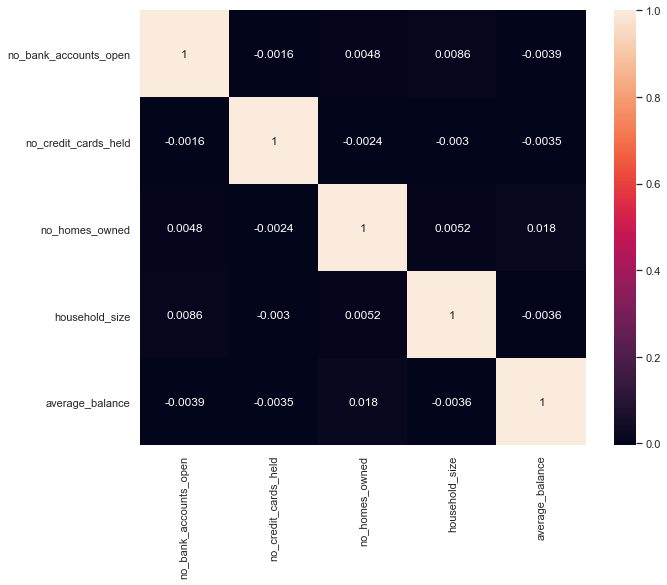

In [21]:
# correlation matrix now shows no high multicollinearity

corr_matrix=numericals_2.corr(method='pearson')  
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [22]:
# drop columns in main dataframe

data = data.drop(columns=['q1_balance','q2_balance','q3_balance'])
data

offer_accepted     reward mailer_type income_level  \
Customer_Number                                                      
1                           No  Air Miles      Letter         High   
2                           No  Air Miles      Letter       Medium   
3                           No  Air Miles    Postcard         High   
4                           No  Air Miles      Letter       Medium   
5                           No  Air Miles      Letter       Medium   
...                        ...        ...         ...          ...   
17996                       No  Cash Back      Letter         High   
17997                       No  Cash Back      Letter         High   
17998                       No  Cash Back      Letter         High   
17999                       No  Cash Back      Letter       Medium   
18000                       No  Cash Back      Letter          Low   

                 no_bank_accounts_open overdraft_protection credit_rating  \
Customer_Number                                                             
1                                    1                   No          High   
2                                    1                   No        Medium   
3                                    2                   No        Medium   
4                                    2                   No          High   
5                                    1                   No        Medium   
...                                ...                  ...           ...   
17996                                1                   No           Low   
17997                                1                   No           Low   
17998                                1                   No           Low   
17999                                1                   No        Medium   
18000                                2                   No        Medium   

                 no_credit_cards_held  no_homes_owned  household_size  \
Customer_Number                                                         
1                                   2               1               4   
2                                   2               2               5   
3                                   2               1               2   
4                                   1               1               4   
5                                   2               1               6   
...                               ...             ...             ...   
17996                               1               1               5   
17997                               3               1               3   
17998                               2               1               4   
17999                               4               2               2   
18000                               2               1               3   

                own_your_home  average_balance  
Customer_Number                                 
1                          No          1160.75  
2                         Yes           147.25  
3                         Yes           276.50  
4                          No          1219.00  
5                         Yes          1211.00  
...                       ...              ...  
17996                     Yes           167.50  
17997                     Yes           850.50  
17998                      No          1087.25  
17999                     Yes          1022.25  
18000                      No          1056.00  

[17976 rows x 12 columns]

### **Categoricals**

In [23]:
# we have 7 categorical variables to explore

data.select_dtypes(include='object')

offer_accepted     reward mailer_type income_level  \
Customer_Number                                                      
1                           No  Air Miles      Letter         High   
2                           No  Air Miles      Letter       Medium   
3                           No  Air Miles    Postcard         High   
4                           No  Air Miles      Letter       Medium   
5                           No  Air Miles      Letter       Medium   
...                        ...        ...         ...          ...   
17996                       No  Cash Back      Letter         High   
17997                       No  Cash Back      Letter         High   
17998                       No  Cash Back      Letter         High   
17999                       No  Cash Back      Letter       Medium   
18000                       No  Cash Back      Letter          Low   

                overdraft_protection credit_rating own_your_home  
Customer_Number                                                   
1                                 No          High            No  
2                                 No        Medium           Yes  
3                                 No        Medium           Yes  
4                                 No          High            No  
5                                 No        Medium           Yes  
...                              ...           ...           ...  
17996                             No           Low           Yes  
17997                             No           Low           Yes  
17998                             No           Low            No  
17999                             No        Medium           Yes  
18000                             No        Medium            No  

[17976 rows x 7 columns]

In [24]:
# now let's look at the relationship between the categorical variables using a chi squared test
# the chi squared test will help us see if there is multicollinearity between categorical variables
# if there is a correlation between columns we can drop one
# let's start with income level vs own your home

data_crosstab = pd.crosstab(data['income_level'], data['own_your_home'], margins=True)
data_crosstab

own_your_home    No    Yes    All
income_level                     
High           1634   2885   4519
Low            1551   2904   4455
Medium         3155   5847   9002
All            6340  11636  17976

In [25]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab)
p_value

0.9042671099694827

In [26]:
chi2_contingency(data_crosstab, correction=False)

# no correlation - we need a chi square score of 12, if we have a 0.05 confidence threshold and 6 degrees of freedom, for there to be a relationship (see below table)

(2.1614506239053406,
 0.9042671099694827,
 6,
 array([[ 1593.81731197,  2925.18268803,  4519.        ],
        [ 1571.24499332,  2883.75500668,  4455.        ],
        [ 3174.9376947 ,  5827.0623053 ,  9002.        ],
        [ 6340.        , 11636.        , 17976.        ]]))

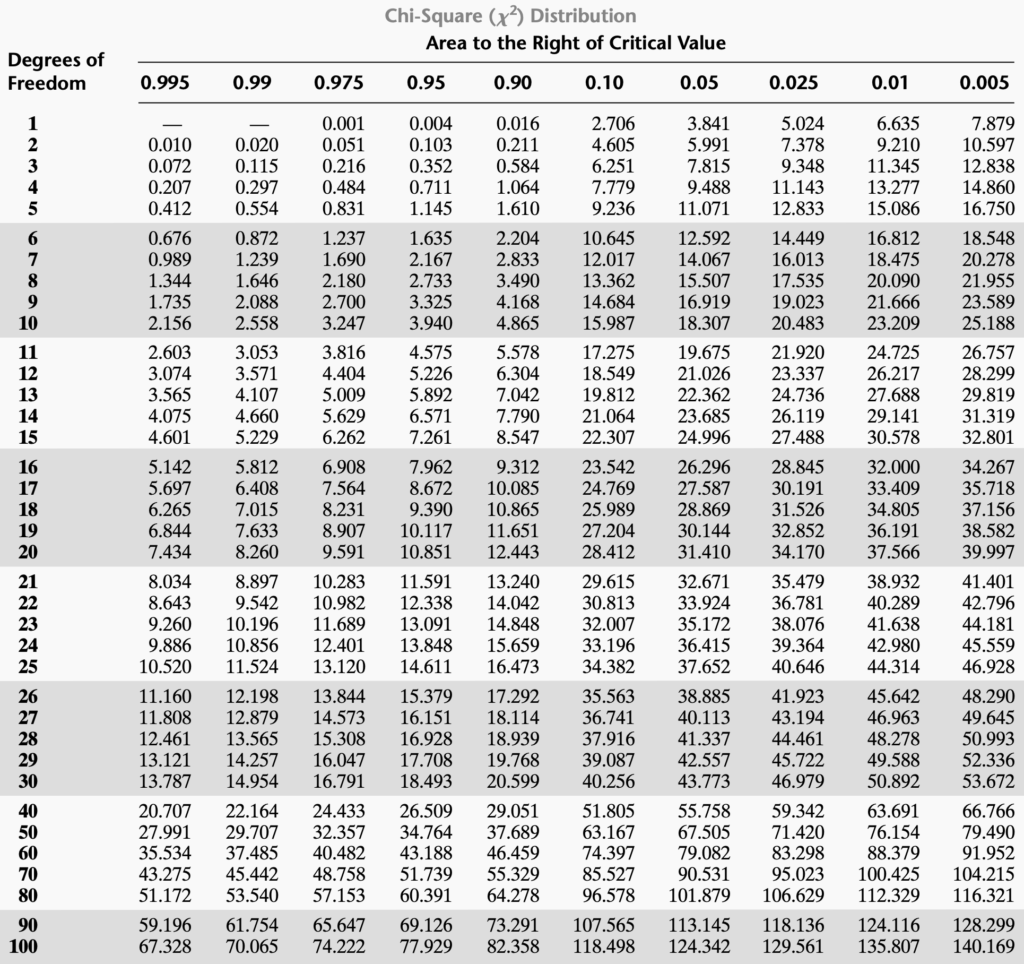

In [27]:
# this table shows us at which chi square stat we can drop a column

from IPython import display
display.Image("Chi-Square-table.png", width=200, height=200)

In [28]:
# income level vs credit rating

data_crosstab_2 = pd.crosstab(data['income_level'], data['credit_rating'], margins=True)
data_crosstab_2

credit_rating  High   Low  Medium    All
income_level                            
High           1512  1526    1481   4519
Low            1539  1439    1477   4455
Medium         3013  2983    3006   9002
All            6064  5948    5964  17976

In [29]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab_2)
p_value

0.9651046686244021

In [30]:
chi2_contingency(data_crosstab_2, correction=False)

# no correlation - we have a chi square score of 3 and degrees of freedom 9. this means we need chi square score of around 17 to drop column  (see above table)


(2.9794361727435366,
 0.9651046686244021,
 9,
 array([[ 1524.43346684,  1495.27214063,  1499.29439252,  4519.        ],
        [ 1502.84379172,  1474.09546061,  1478.06074766,  4455.        ],
        [ 3036.72274143,  2978.63239875,  2986.64485981,  9002.        ],
        [ 6064.        ,  5948.        ,  5964.        , 17976.        ]]))

In [31]:
# credit rating vs own your home

data_crosstab_3 = pd.crosstab(data['credit_rating'], data['own_your_home'], margins=True)


In [32]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab_3)
chi2_contingency(data_crosstab_3, correction=False)

# there is also no correlation here so no need to remove the column

(1.0598226785449683,
 0.9832425002420585,
 6,
 array([[ 2138.72719181,  3925.27280819,  6064.        ],
        [ 2097.81486426,  3850.18513574,  5948.        ],
        [ 2103.45794393,  3860.54205607,  5964.        ],
        [ 6340.        , 11636.        , 17976.        ]]))

## **1st Run - Logistic Regression**  

- First I will apply the sklearn logistic regression model to the data without having dealt with the class imbalace.  

- Logistic regression models the probability of a row belonging to one of two classes.

- This run is just for some benchmarking to see how the model deals with the imbalanced data before applying any changes or transformations to deal with the imbalance. After this I will come back and deal with the imbalance and test the model again.

In [33]:
# let's fit the logistic regression model now with no changes to the data - just for benchmarking

# x/y split

y = data['offer_accepted']
X = data.drop('offer_accepted', axis=1)

In [34]:
# encode categoricals

X = pd.get_dummies(X)
X

no_bank_accounts_open  no_credit_cards_held  no_homes_owned  \
Customer_Number                                                                
1                                    1                     2               1   
2                                    1                     2               2   
3                                    2                     2               1   
4                                    2                     1               1   
5                                    1                     2               1   
...                                ...                   ...             ...   
17996                                1                     1               1   
17997                                1                     3               1   
17998                                1                     2               1   
17999                                1                     4               2   
18000                                2                     2               1   

                 household_size  average_balance  reward_Air Miles  \
Customer_Number                                                      
1                             4          1160.75                 1   
2                             5           147.25                 1   
3                             2           276.50                 1   
4                             4          1219.00                 1   
5                             6          1211.00                 1   
...                         ...              ...               ...   
17996                         5           167.50                 0   
17997                         3           850.50                 0   
17998                         4          1087.25                 0   
17999                         2          1022.25                 0   
18000                         3          1056.00                 0   

                 reward_Cash Back  reward_Points  mailer_type_Letter  \
Customer_Number                                                        
1                               0              0                   1   
2                               0              0                   1   
3                               0              0                   0   
4                               0              0                   1   
5                               0              0                   1   
...                           ...            ...                 ...   
17996                           1              0                   1   
17997                           1              0                   1   
17998                           1              0                   1   
17999                           1              0                   1   
18000                           1              0                   1   

                 mailer_type_Postcard  income_level_High  income_level_Low  \
Customer_Number                                                              
1                                   0                  1                 0   
2                                   0                  0                 0   
3                                   1                  1                 0   
4                                   0                  0                 0   
5                                   0                  0                 0   
...                               ...                ...               ...   
17996                               0                  1                 0   
17997                               0                  1                 0   
17998                               0                  1                 0   
17999                               0                  0                 0   
18000                               0                  0                 1   

                 income_level_Medium  overdraft_protection_No  \
Customer_Number                                 

In [35]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# fit model

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [37]:
# overall accuracy score

classification.score(X_test, y_test)

0.9468854282536151

In [38]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[3405,    0],
       [ 191,    0]])

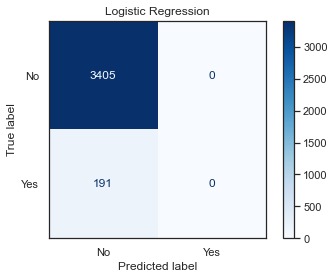

In [39]:
# confusion matrix to show true vs predicted
sns.set_style('white')

fig = plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.title('Logistic Regression')
plt.show()


### **Conclusions after first run**

- High overall accuracy score of 0.95 **BUT**
- Model predicted 0 Yes (either falsely or correctly).
- There is therefore a big problem with predicting the minority class - this is due to the data imbalance. 
- The accuracy score of around 0.95 is explained by the fact that around 95% of the data belongs to one of the 2 classes of our target variable. The model has not learned how to identify rows which belong to the minority class.
- An accuracy score of 0.95 may sound good but we want to try and make a model here which can predict the minorty class well. 
- This model is clearly not doing that so next I will try some different methods of dealing with the data imbalance to see if we can improve performance on the minority class.

---

## **2nd Run - Logistic Regression & SMOTE**  

- Time to try again but this time I will:
  - deal with the outliers in the data.
  - use a mehtod called SMOTE to deal with the data imbalance to try and improve performance in identifiying the minority class.

In [40]:
# copy of the data

data_cleaned = data.copy()

# some boxplots to visualise the spread of the variables and to check which columns have outliers to deal with

for col in data_cleaned.select_dtypes(np.number):
    px.box(data_cleaned[col],width=400, height=400).show()

In [41]:
# function to winsorize the relevant columns to remove outliers
# winsorizing the columns will remove outliers by capping each column at a certain percentile (here I chose to cap the values at the bottom and top 20%)

def winsorizer(df,cols=[]):
    for col in cols:
        df[col] = winsorize(df[col],limits=[0.2,0.2])
    return df
    

In [42]:
# apply function to columns with most outliers

winsorizer(data_cleaned,cols=data_cleaned[['household_size','average_balance','no_credit_cards_held']])

offer_accepted     reward mailer_type income_level  \
Customer_Number                                                      
1                           No  Air Miles      Letter         High   
2                           No  Air Miles      Letter       Medium   
3                           No  Air Miles    Postcard         High   
4                           No  Air Miles      Letter       Medium   
5                           No  Air Miles      Letter       Medium   
...                        ...        ...         ...          ...   
17996                       No  Cash Back      Letter         High   
17997                       No  Cash Back      Letter         High   
17998                       No  Cash Back      Letter         High   
17999                       No  Cash Back      Letter       Medium   
18000                       No  Cash Back      Letter          Low   

                 no_bank_accounts_open overdraft_protection credit_rating  \
Customer_Number                                                             
1                                    1                   No          High   
2                                    1                   No        Medium   
3                                    2                   No        Medium   
4                                    2                   No          High   
5                                    1                   No        Medium   
...                                ...                  ...           ...   
17996                                1                   No           Low   
17997                                1                   No           Low   
17998                                1                   No           Low   
17999                                1                   No        Medium   
18000                                2                   No        Medium   

                 no_credit_cards_held  no_homes_owned  household_size  \
Customer_Number                                                         
1                                   2               1               4   
2                                   2               2               4   
3                                   2               1               3   
4                                   1               1               4   
5                                   2               1               4   
...                               ...             ...             ...   
17996                               1               1               4   
17997                               3               1               3   
17998                               2               1               4   
17999                               3               2               3   
18000                               2               1               3   

                own_your_home  average_balance  
Customer_Number                                 
1                          No          1160.75  
2                         Yes           728.50  
3                         Yes           728.50  
4                          No          1192.75  
5                         Yes          1192.75  
...                       ...              ...  
17996                     Yes           728.50  
17997                     Yes           850.50  
17998                      No          1087.25  
17999                     Yes          1022.25  
18000                      No          1056.00  

[17976 rows x 12 columns]

In [43]:
# boxplots show outliers have been dealt with in the above columns
# the remaining columns still have some outliers but the values are too squished together so by capping the outliers I think we would lose too much data

for col in data_cleaned.select_dtypes(np.number):
    px.box(data_cleaned[col],width=400, height=400).show()

In [44]:
# now let's deal with the data imbalance

data_cleaned['offer_accepted'].value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

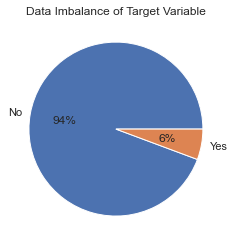

In [45]:
# we can see from this pie chart 94% of the values in the target column belong to one class (people who did not accept the credit card offer)

fig, ax = plt.subplots()
ax.pie(data_cleaned['offer_accepted'].value_counts(), autopct='%.0f%%',labels=['No','Yes'])
plt.title('Data Imbalance of Target Variable')
plt.show()

In [46]:
# before applying the sampling method we need to split the data
# x/y split

y_cleaned = data_cleaned['offer_accepted']
X_cleaned = data_cleaned.drop('offer_accepted', axis=1)

In [47]:
# dummify the categoricals 

X_cleaned = pd.get_dummies(X_cleaned)
X_cleaned

no_bank_accounts_open  no_credit_cards_held  no_homes_owned  \
Customer_Number                                                                
1                                    1                     2               1   
2                                    1                     2               2   
3                                    2                     2               1   
4                                    2                     1               1   
5                                    1                     2               1   
...                                ...                   ...             ...   
17996                                1                     1               1   
17997                                1                     3               1   
17998                                1                     2               1   
17999                                1                     3               2   
18000                                2                     2               1   

                 household_size  average_balance  reward_Air Miles  \
Customer_Number                                                      
1                             4          1160.75                 1   
2                             4           728.50                 1   
3                             3           728.50                 1   
4                             4          1192.75                 1   
5                             4          1192.75                 1   
...                         ...              ...               ...   
17996                         4           728.50                 0   
17997                         3           850.50                 0   
17998                         4          1087.25                 0   
17999                         3          1022.25                 0   
18000                         3          1056.00                 0   

                 reward_Cash Back  reward_Points  mailer_type_Letter  \
Customer_Number                                                        
1                               0              0                   1   
2                               0              0                   1   
3                               0              0                   0   
4                               0              0                   1   
5                               0              0                   1   
...                           ...            ...                 ...   
17996                           1              0                   1   
17997                           1              0                   1   
17998                           1              0                   1   
17999                           1              0                   1   
18000                           1              0                   1   

                 mailer_type_Postcard  income_level_High  income_level_Low  \
Customer_Number                                                              
1                                   0                  1                 0   
2                                   0                  0                 0   
3                                   1                  1                 0   
4                                   0                  0                 0   
5                                   0                  0                 0   
...                               ...                ...               ...   
17996                               0                  1                 0   
17997                               0                  1                 0   
17998                               0                  1                 0   
17999                               0                  0                 0   
18000                               0                  0                 1   

                 income_level_Medium  overdraft_protection_No  \
Customer_Number                                 

In [48]:
# train/test split 

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)


In [49]:
# the first method I will try to deal with the data imbalance is SMOTE - this will synthesise new rows in the minority class to rebalance the data
# as we can see - we now have an equal amount of Yes & No

smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X_train, y_train)
y_sm.value_counts()

No     13550
Yes    13550
Name: offer_accepted, dtype: int64

In [50]:
# fit the model to the training data

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_sm, y_sm)

LogisticRegression(max_iter=10000, random_state=42)

In [51]:
classification.score(X_test, y_test)


0.92880978865406

In [52]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[3306,   99],
       [ 157,   34]])

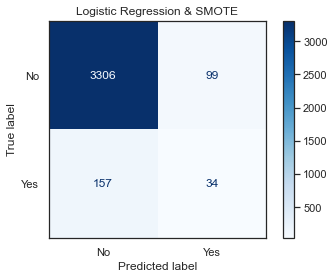

In [53]:
# from the confusion matrix we can see the model is predicting a small amount of the minorty class correctly so it is doing a better job than the first run, however still not good.
sns.set_style('white')
plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.title('Logistic Regression & SMOTE')
plt.show()

In [55]:
# the classification shows us the precision and recall scores which are important for checking model performance on the minority class.
# in such a case with a huge data imbalance, if we want to build a model which can correctly predict the minorty class we should look at the precision & recall scores instead of the overall accuracy score.
# the scores here after using smote are still very low so
# looks like we need to try a different sampling method to deal with the data imbalance...

print(classification_report(y_test, classification.predict(X_test)))


              precision    recall  f1-score   support

          No       0.95      0.97      0.96      3405
         Yes       0.26      0.18      0.21       191

    accuracy                           0.93      3596
   macro avg       0.61      0.57      0.59      3596
weighted avg       0.92      0.93      0.92      3596



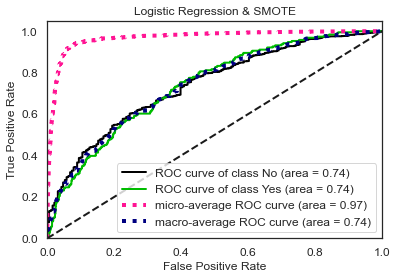

In [56]:
# the ROC curve plots the true postive rate against the false positive rate at different probability thresholds to visualise model performance for both classes
# the more the curve looks like an L which has fallen over to the right the better the model :)

y_probas = classification.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title('Logistic Regression & SMOTE')
plt.show()

### **Conclusions after second run using smote**  

- Accuracy score slightly worse than first run and only a slightly better performance on minority class after using the smote method to deal with the class imbalance.
- For this project I will focus on the precision and recall scores because, as mentioned above, the dataset is hugely imbalanced towards one class and the aim here is to improve model performance at identifying the minority class (around 6% of the data).
- **Recall** is the proportion of correctly identified true positives. Recall score here is 0.15 - this model performing very badly at correctly identifying Yes.
- We should focus on recall if the *quantity* of identified Yes is more important
- **Precision** is the proportion of true positives to all positives. Precision score here is 0.21 -  model doing slightly better (but still very poorly) at identifying true Yes (from all the predicted Yes, how many are actually Yes).
- We should focus on precision if the *quality* of identified yes is more important.
- ROC curve also shows poor performance on the Yes class.
- Looks like SMOTE is not suitable for this data so  we need to try another method to deal with the data imbalance...

---

## **3rd run - Logistic Regression & Undersampling**

- Another method we can use to deal the class imbalance is undersampling.
- This reduces the amount of rows in the majority class to even out the distrbution of the 2 classes.

In [57]:
# copy of cleaned data (no need to do data cleaning/transformations again)

data_copy = data_cleaned.copy()

In [58]:
# x/y split

y = data_copy['offer_accepted']
X = data_copy.drop('offer_accepted', axis=1)

In [59]:
# encode categoricals

X = pd.get_dummies(X)

In [60]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# return to one df

training_set = pd.concat([X_train, y_train], axis=1)

# seperate minority & majority classes

yes = training_set[training_set.offer_accepted == 'Yes']
no = training_set[training_set.offer_accepted == 'No']

In [61]:
# use undersampling method to make distribution of Yes & No 50/50

undersample = resample(no, 
                       replace=True, 
                       n_samples=len(yes), #set the number of samples to equal the number of the minority class
                       random_state=42)
# Returning to new training set
undersample_train = pd.concat([yes, undersample])
undersample_train.offer_accepted.value_counts(normalize=True)

# now we have an equal distrubtion of the 2 classes of the target variable

No     0.5
Yes    0.5
Name: offer_accepted, dtype: float64

In [62]:
# split into x/y sets again

undersample_x_train = undersample_train.drop('offer_accepted', axis=1)
undersample_y_train = undersample_train.offer_accepted

In [63]:
# fit model

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(undersample_x_train, undersample_y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [64]:
# check accuracy score against test data (no changes applied to test data to avoid data leakage)
# accuracy score much lower than previous 2 runs

classification.score(X_test, y_test)

0.6329254727474972

In [65]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[2132, 1273],
       [  47,  144]])

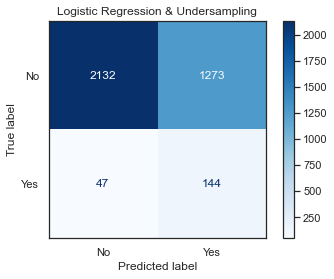

In [66]:
# confusion matrix shows the model performing much better at identifying the minorty class after undersampling the majority class


plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.title('Logistic Regression & Undersampling')
plt.show()

In [67]:
# recall has improved from around 0.2 with SMOTE to 0.75 with undersampling
# however the precision is very low as our model predicted a lot of Nos as Yes (false positives)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.98      0.63      0.76      3405
         Yes       0.10      0.75      0.18       191

    accuracy                           0.63      3596
   macro avg       0.54      0.69      0.47      3596
weighted avg       0.93      0.63      0.73      3596



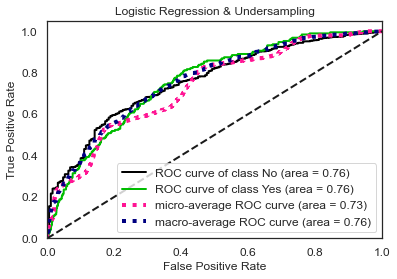

In [68]:
y_probas = classification.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title('Logistic Regression & Undersampling')
plt.show()

### **Conclusions after 3rd run using undersampling**  

- Undersampling the majority class seems to be much more effective than SMOTE at helping to identify the Yes class.
- Recall has improved from 0.16 to 0.75 indicating a much larger quantity of the minorty class is being identified.
- Precision however has decreased from 0.24 to 0.1 - indicating the model has overcompensated to identify the Yes class at all costs. The quality of the identified minority class is low.
- If we want to identify the yes at all cost - we should go with undersampling.  
- If we used the model for prediction the downside would be incorrectly predicting many customers to say yes to the credit card offer (false positives) - hence the low precision.
- The high recall does mean the model is better at picking up any yes at all compared to SMOTE.
- As we can see from the ROC curve, the undersampling has reduced model peformance on the No class - many rows are being predicted to be Yes when they are actually No.

---

## **4th run - Logistic Regression & Oversampling**    

- Now I will try logistic regression with the oversampling method. This is essentially the opposite of undersampling
- This will increase the amount of rows in the minority class to match the majority class.

In [69]:
# we already did the yes/no split in the undersampling run so now just need to resample yes instead of no

oversample = resample(yes, 
                       replace=True, 
                       n_samples=len(no), #set the number of samples to equal the number of the majority class
                       random_state=42)
# Returning to new training set
oversample_train = pd.concat([no, oversample])
oversample_train.offer_accepted.value_counts(normalize=True)

No     0.5
Yes    0.5
Name: offer_accepted, dtype: float64

In [70]:
# x/y split again

oversample_x_train = oversample_train.drop('offer_accepted', axis=1)
oversample_y_train = oversample_train.offer_accepted

In [71]:
# fit model to oversampled training data

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(oversample_x_train, oversample_y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [72]:
# check accuracy score againt unseen test data
# similar to undersampling

classification.score(X_test, y_test)

0.6504449388209121

In [73]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[2196, 1209],
       [  48,  143]])

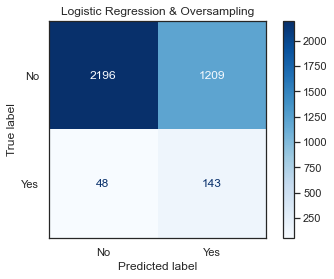

In [74]:
# confusion matrix shows a very similar performance to undersampling

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.title('Logistic Regression & Oversampling')
plt.show()

In [75]:
# the classification report is almost identical to the undersampling one

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.98      0.64      0.78      3405
         Yes       0.11      0.75      0.19       191

    accuracy                           0.65      3596
   macro avg       0.54      0.70      0.48      3596
weighted avg       0.93      0.65      0.75      3596



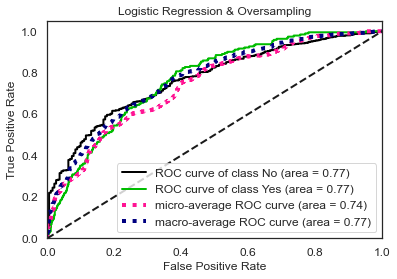

In [76]:
# ROC curve also very similar to the undersampling one

y_probas = classification.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title('Logistic Regression & Oversampling')
plt.show()

### **Conclusions after 4th run using oversampling** 

- Very similar results to undersampling.
- Recall, precision and ROC scores are essentially the same.
- We can thus make the same conclusions as with undersampling - the performance will decrease on No class and increase on Yes class, however precision is still very low because the  model is predicting many Nos as Yes (false positives).
- So we can conclude that over or undersampling the data for the majority/minorty class helps the logistic regression model to pick up more of the minority class, at the expense of general accuracy and predicting the majority class correctly.
- Next I will try a mix of both under and oversampling to see if we can improve the model...

---


## **5th Run - Logistic Regression & a Combination of Over/Undersampling**  

- Finally I will try a combination of random over and undersampling to see if that improves our logistic regression model.

In [77]:
# copy of cleaned data

data_copy2 = data_cleaned.copy()

In [78]:
# x/y split

y = data_copy2['offer_accepted']
X = data_copy2.drop('offer_accepted', axis=1)

# encode categoricals

X = pd.get_dummies(X)

In [79]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [80]:
# here i will use a random undersampler and random oversampler from imblearn

under = RandomUnderSampler(sampling_strategy=0.8, random_state=101)
over = RandomOverSampler(sampling_strategy=0.5, random_state=101)

In [81]:
X_over, y_over = over.fit_resample(X_train, y_train)
print(f"Oversampled: {Counter(y_over)}")


Oversampled: Counter({'No': 13550, 'Yes': 6775})


In [82]:
X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)
print(f"Combined Random Over &  Undersampling: {Counter(y_combined_sampling)}")


Combined Random Over &  Undersampling: Counter({'No': 8468, 'Yes': 6775})


In [83]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_combined_sampling, y_combined_sampling)

LogisticRegression(max_iter=10000, random_state=42)

In [84]:
# accuracy score has improved by around 0.1 compared to over & undersampling

classification.score(X_test, y_test)

0.7411012235817576

In [85]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[2545,  860],
       [  71,  120]])

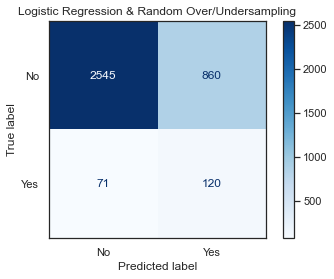

In [86]:
plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.title('Logistic Regression & Random Over/Undersampling')
plt.show()

In [87]:
# overall recall is down around 0.10 compared to over & undersampling.

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.97      0.75      0.85      3405
         Yes       0.12      0.63      0.20       191

    accuracy                           0.74      3596
   macro avg       0.55      0.69      0.53      3596
weighted avg       0.93      0.74      0.81      3596



### **Conclusions after 5th run using a combination of random over and undersampling**  

- Lower recall than pure over or undersampling but better peformance on the majority class.
- Higher overall accuracy score then pure under or oversampling.
- This model does a better job overall than the previous two but for this business case I would not recommed it as we are focusing on making our model perform well on the minority class.



---

## **6th Run - KNN & Random Sampling**  

- Now I will try the KNN algorithm.
- KNN assumes that similar datapoints or rows are near each other (on the cartesian plane). The algorithm takes a vote from k amount of the nearest neighbours of a row and classifies the row into the class with the most votes.
- To deal with the data imbalance I will use random over and under sampling.

In [88]:
# copy of data

KNN_data = data.copy()

In [89]:
# x/y split

y = KNN_data['offer_accepted']
X = KNN_data.drop('offer_accepted', axis=1)

In [90]:
# encode categoricals

X = pd.get_dummies(X)
X

no_bank_accounts_open  no_credit_cards_held  no_homes_owned  \
Customer_Number                                                                
1                                    1                     2               1   
2                                    1                     2               2   
3                                    2                     2               1   
4                                    2                     1               1   
5                                    1                     2               1   
...                                ...                   ...             ...   
17996                                1                     1               1   
17997                                1                     3               1   
17998                                1                     2               1   
17999                                1                     4               2   
18000                                2                     2               1   

                 household_size  average_balance  reward_Air Miles  \
Customer_Number                                                      
1                             4          1160.75                 1   
2                             5           147.25                 1   
3                             2           276.50                 1   
4                             4          1219.00                 1   
5                             6          1211.00                 1   
...                         ...              ...               ...   
17996                         5           167.50                 0   
17997                         3           850.50                 0   
17998                         4          1087.25                 0   
17999                         2          1022.25                 0   
18000                         3          1056.00                 0   

                 reward_Cash Back  reward_Points  mailer_type_Letter  \
Customer_Number                                                        
1                               0              0                   1   
2                               0              0                   1   
3                               0              0                   0   
4                               0              0                   1   
5                               0              0                   1   
...                           ...            ...                 ...   
17996                           1              0                   1   
17997                           1              0                   1   
17998                           1              0                   1   
17999                           1              0                   1   
18000                           1              0                   1   

                 mailer_type_Postcard  income_level_High  income_level_Low  \
Customer_Number                                                              
1                                   0                  1                 0   
2                                   0                  0                 0   
3                                   1                  1                 0   
4                                   0                  0                 0   
5                                   0                  0                 0   
...                               ...                ...               ...   
17996                               0                  1                 0   
17997                               0                  1                 0   
17998                               0                  1                 0   
17999                               0                  0                 0   
18000                               0                  0                 1   

                 income_level_Medium  overdraft_protection_No  \
Customer_Number                                 

In [91]:
# train/test split

KNN_X_train, KNN_X_test, KNN_y_train, KNN_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# scale data to prepare for fitting of KNN model
# the KNN model requires the data to be on the same scale so the model isn't biased towards variables with higher magnitude

# transformer will be saved here - use same transformer for test set

transformer = StandardScaler().fit(KNN_X_train)
KNN_x_standardized = transformer.transform(KNN_X_train)
KNN_x_standardized

array([[ 3.69023316, -1.12898721,  1.86618159, ..., -0.7070699 ,
        -0.73480903,  0.73480903],
       [-0.53691886,  0.12641304,  1.86618159, ...,  1.41428732,
        -0.73480903,  0.73480903],
       [-0.53691886,  0.12641304,  1.86618159, ..., -0.7070699 ,
         1.36089781, -1.36089781],
       ...,
       [ 1.57665715,  0.12641304, -0.47693299, ...,  1.41428732,
         1.36089781, -1.36089781],
       [-0.53691886, -1.12898721, -0.47693299, ..., -0.7070699 ,
        -0.73480903,  0.73480903],
       [-0.53691886, -1.12898721, -0.47693299, ..., -0.7070699 ,
         1.36089781, -1.36089781]])

In [93]:
# scale test set using same transfomer

KNN_x_test_standardized = transformer.transform(KNN_X_test)
KNN_x_test_standardized

array([[-0.53691886,  0.12641304,  1.86618159, ...,  1.41428732,
        -0.73480903,  0.73480903],
       [-0.53691886,  1.38181329, -0.47693299, ..., -0.7070699 ,
        -0.73480903,  0.73480903],
       [-0.53691886,  0.12641304, -0.47693299, ...,  1.41428732,
         1.36089781, -1.36089781],
       ...,
       [-0.53691886,  0.12641304,  1.86618159, ..., -0.7070699 ,
         1.36089781, -1.36089781],
       [-0.53691886,  2.63721354, -0.47693299, ..., -0.7070699 ,
         1.36089781, -1.36089781],
       [-0.53691886, -1.12898721, -0.47693299, ..., -0.7070699 ,
        -0.73480903,  0.73480903]])

In [94]:
# apply KNN model with a few diffent k values between 1 & 10 to see which one gives us the best score

scores = []
for i in range(1,10,2):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(KNN_x_standardized, KNN_y_train)
    y_pred = model.predict(KNN_x_test_standardized)
    scores.append((metrics.accuracy_score(KNN_y_test, y_pred)))
scores

[0.9032258064516129,
 0.9302002224694105,
 0.9418798665183538,
 0.9443826473859844,
 0.9441045606229144]

Text(0, 0.5, 'Accuracy')

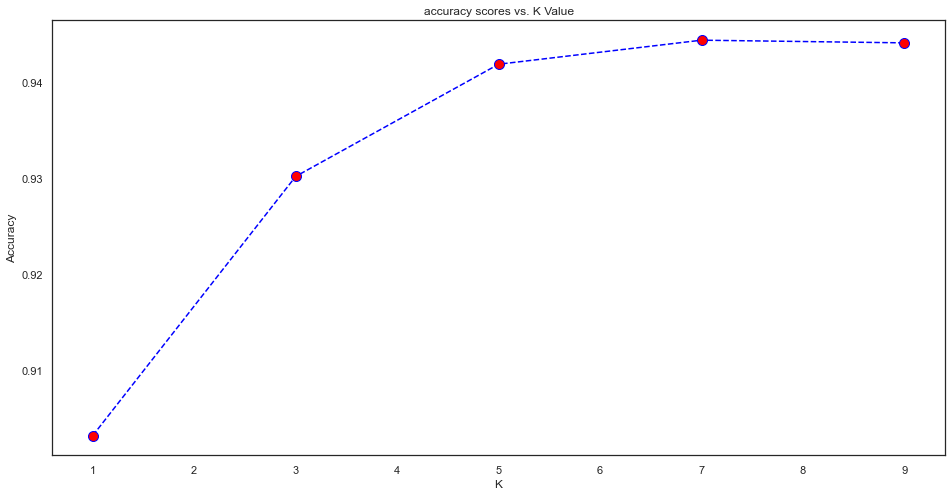

In [95]:
# from the graph below we can see a k value of around 8/9 is best for total accuracy

plt.figure(figsize=(16,8))
plt.plot(range(1,10,2),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('accuracy scores vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

# best k-value for accuracy score is around 9

**However, as with logistic regression the focus of our models is on the minorty class so overall accuracy is not the metric I would focus on. We still need to check the performance on the minority class just as we did with logistic regression**

In [96]:
# try with k=9 & with random over and under sampling to deal with class imbalance.

KNN_model = KNeighborsClassifier(n_neighbors=9)

under = RandomUnderSampler(sampling_strategy=0.8, random_state=101)
over = RandomOverSampler(sampling_strategy=0.6, random_state=101)

# first oversample the minority class
X_over, y_over = over.fit_resample(KNN_x_standardized, KNN_y_train)

# then undersample majority class and combine

X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)


In [97]:
# fit model to randomly over and undersampled training data

KNN_model.fit(X_combined_sampling, y_combined_sampling)

KNeighborsClassifier(n_neighbors=9)

In [98]:
# test model against test set

predictions_KNN = KNN_model.predict(KNN_x_test_standardized)
confusion_matrix(KNN_y_test, predictions_KNN)

array([[2472,  933],
       [ 114,   77]])

In [99]:
# accuracy score

KNN_model.score(KNN_x_test_standardized, KNN_y_test)

0.7088431590656284

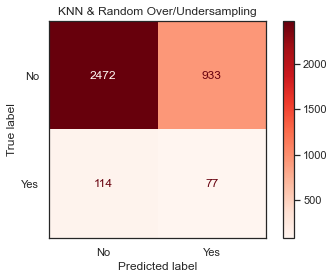

In [100]:
plot_confusion_matrix(KNN_model, KNN_x_test_standardized, KNN_y_test, cmap='Reds')
plt.title('KNN & Random Over/Undersampling')
plt.show()

In [101]:
print(metrics.classification_report(KNN_y_test, predictions_KNN))

              precision    recall  f1-score   support

          No       0.96      0.73      0.83      3405
         Yes       0.08      0.40      0.13       191

    accuracy                           0.71      3596
   macro avg       0.52      0.56      0.48      3596
weighted avg       0.91      0.71      0.79      3596



### **Conclusions after 6th run using KNN & a combination of random over and undersampling**  

- Overall poor performance compared to logistic regression.
- The model is not doing a good job of picking up the minority class.
- I would therefore not use KNN with the random over & undersampling method.
- Next I will try with KNN again but this time using pure undersampling.



---

## **7th Run - KNN & Oversampling**  

- Time for another try with the KNN algorithm.
- To deal with the data imbalance I will use oversampling of the minority class.

In [102]:
# concat training set again

training_set = pd.concat([KNN_X_train, KNN_y_train], axis=1)

# seperate minority & majority classes

yes = training_set[training_set.offer_accepted == 'Yes']
no = training_set[training_set.offer_accepted == 'No']

In [103]:
oversample = resample(yes, 
                       replace=True, 
                       n_samples=len(no), #set the number of samples to equal the number of the majority class
                       random_state=42)
# Returning to new training set
oversample_train = pd.concat([no, oversample])
oversample_train.offer_accepted.value_counts(normalize=True)

No     0.5
Yes    0.5
Name: offer_accepted, dtype: float64

In [104]:
# x/y split again

oversample_x_train = oversample_train.drop('offer_accepted', axis=1)
oversample_y_train = oversample_train.offer_accepted

In [105]:
transformer = StandardScaler().fit(oversample_x_train)
KNN2_x_standardized = transformer.transform(oversample_x_train)
KNN2_x_standardized

array([[ 3.74921273, -1.11682545,  1.83622881, ..., -0.66219727,
        -0.73785063,  0.73785063],
       [-0.54692532,  0.13336951,  1.83622881, ...,  1.51012401,
        -0.73785063,  0.73785063],
       [-0.54692532,  0.13336951,  1.83622881, ..., -0.66219727,
         1.35528786, -1.35528786],
       ...,
       [-0.54692532,  1.38356446, -0.48032073, ..., -0.66219727,
        -0.73785063,  0.73785063],
       [-0.54692532, -1.11682545, -0.48032073, ..., -0.66219727,
        -0.73785063,  0.73785063],
       [-0.54692532,  0.13336951, -0.48032073, ..., -0.66219727,
         1.35528786, -1.35528786]])

In [106]:
KNN2_x_test_standardized = transformer.transform(KNN_X_test)
KNN2_x_test_standardized

array([[-0.54692532,  0.13336951,  1.83622881, ...,  1.51012401,
        -0.73785063,  0.73785063],
       [-0.54692532,  1.38356446, -0.48032073, ..., -0.66219727,
        -0.73785063,  0.73785063],
       [-0.54692532,  0.13336951, -0.48032073, ...,  1.51012401,
         1.35528786, -1.35528786],
       ...,
       [-0.54692532,  0.13336951,  1.83622881, ..., -0.66219727,
         1.35528786, -1.35528786],
       [-0.54692532,  2.63375942, -0.48032073, ..., -0.66219727,
         1.35528786, -1.35528786],
       [-0.54692532, -1.11682545, -0.48032073, ..., -0.66219727,
        -0.73785063,  0.73785063]])

In [107]:
KNN_model.fit(KNN2_x_standardized, oversample_y_train)

KNeighborsClassifier(n_neighbors=9)

In [108]:
predictions_KNN2 = KNN_model.predict(KNN2_x_test_standardized)
confusion_matrix(KNN_y_test, predictions_KNN2)

array([[2632,  773],
       [ 121,   70]])

In [109]:
# accuracy score
KNN_model.score(KNN2_x_test_standardized, KNN_y_test)

0.7513904338153504

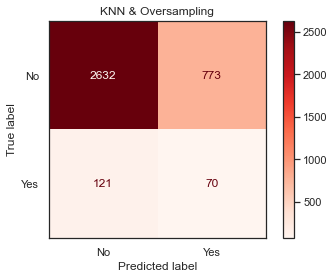

In [110]:
plot_confusion_matrix(KNN_model, KNN2_x_test_standardized, KNN_y_test, cmap='Reds')
plt.title('KNN & Oversampling')
plt.show()

In [111]:
# recall and precision are lower than using KNN with random over & undersampling

print(metrics.classification_report(KNN_y_test, predictions_KNN2))

              precision    recall  f1-score   support

          No       0.96      0.77      0.85      3405
         Yes       0.08      0.37      0.14       191

    accuracy                           0.75      3596
   macro avg       0.52      0.57      0.50      3596
weighted avg       0.91      0.75      0.82      3596



### **Conclusions after 7th run using KNN & oversampling**  

- Worse performance than logistic regression and worse than using KNN with random over/undersampling.
- The model is not doing a good job of picking up the minority class.
- I wouldn't use any of the KNN models to try and identify the minority class. Logistic regression with either under or over sampling seems to be a better fit for this dataset.



---

## **8th Run - Random Forest**  

- Another algorithm we can try is random forest.
- Random forest creates N number of decision trees for each row which each provide a prediction as to which class the row belongs to. The class with the most votes wins.
- First I will fit the random forest algorithm to the data without dealing with the class imbalance, just for benchmarking.

In [112]:
# make another copy of original data before any data transformations/cleaning
# random forest is not sensitive to outliers so we don't need to deal with them

RF_data = data.copy()

# x/y split

y = RF_data['offer_accepted']
X = RF_data.drop('offer_accepted', axis=1)

# dummify categoricals

X = pd.get_dummies(X)

In [113]:
# define random forest model

RF_model = RandomForestClassifier(n_estimators=150, random_state=101)

# train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

# train model

RF_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=101)

In [114]:
# accuracy score
RF_model.score(X_test, y_test)

0.931868743047831

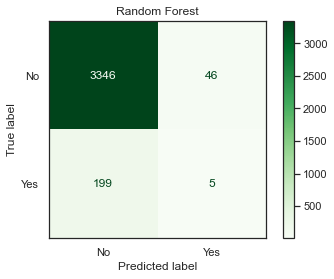

In [115]:
# prediction result
RF_predictions = RF_model.predict(X_test)

#Create confusion matrix
fig = plot_confusion_matrix(RF_model, X_test, y_test, display_labels=['No', 'Yes'], cmap='Greens')
plt.title('Random Forest')
plt.show()

In [116]:
print(metrics.classification_report(y_test, RF_predictions))

              precision    recall  f1-score   support

          No       0.94      0.99      0.96      3392
         Yes       0.10      0.02      0.04       204

    accuracy                           0.93      3596
   macro avg       0.52      0.51      0.50      3596
weighted avg       0.90      0.93      0.91      3596



### **Conclusions after 8th run using Random Forest**  

- Very similar to logistic regression and KNN (with no sampling changes).
- High accuracy due to data imbalance but very low scores on the minority class.
- Just like with logistic regression and KNN we need to deal with the data imbalance.


---

## **9th Run - Random Forest & SMOTE**  

- This time I will try random forest with SMOTE to try and deal with the class imbalance.
- This is the same SMOTE as with logistic regression - it will synthesise rows in the minority class.

In [117]:
# we already did the x/y split above so now just need to apply smote method

oversample = SMOTE()

# define classifier

SMOTE_RF = RandomForestClassifier(n_estimators=150, random_state=101)

# use SMOTE on train/test set 

over_X_train, over_y_train = oversample.fit_resample(X_train, y_train)


In [118]:
# fit model to train set

SMOTE_RF.fit(over_X_train, over_y_train)

# create predictions variable

predictions = SMOTE_RF.predict(X_test)


In [119]:
# accuracy score

SMOTE_RF.score(X_test, y_test)

0.9302002224694105

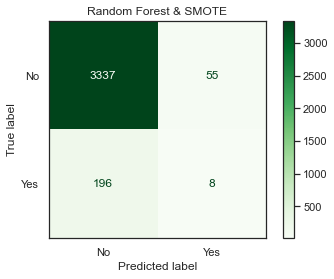

In [120]:
fig = plot_confusion_matrix(SMOTE_RF, X_test, y_test, display_labels=['No', 'Yes'], cmap='Greens')
plt.title('Random Forest & SMOTE')
plt.show()

In [121]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.94      0.98      0.96      3392
         Yes       0.13      0.04      0.06       204

    accuracy                           0.93      3596
   macro avg       0.54      0.51      0.51      3596
weighted avg       0.90      0.93      0.91      3596



### **Conclusions after 9th run using Random Forest & SMOTE**  

- Only a very marginal improvment in terms of precision & recall compared to random forest without any sampling methods.
- Overall random forest does not seem to be a good fit for this data set in terms of identifying the minority class.

---

# **Conclusion & Comparison Table**

|        Model        |          Sampling           | Precision (Minority class) | Recall (Minority class) | Accuracy |
| :-----------------: | :-------------------------: | -------------------------: | ----------------------: | -------: |
| Logistic Regression |              -              |                          0 |                       0 |     0.95 |
| Logistic Regression |            SMOTE            |                       0.26 |                    0.18 |     0.93 |
| Logistic Regression |        Undersampling        |                       0.10 |                    0.75 |     0.63 |
| Logistic Regression |        Oversampling         |                       0.11 |                    0.75 |     0.65 |
| Logistic Regression | Random over & undersampling |                       0.12 |                    0.63 |     0.74 |
|     KNN  (K=9)      | Random over & undersampling |                       0.08 |                    0.40 |     0.70 |
|     KNN  (K=9)      |        Oversampling         |                       0.08 |                    0.37 |     0.75 |
|    Random Forest    |              -              |                       0.10 |                    0.02 |     0.93 |
|    Random Forest    |            SMOTE            |                       0.13 |                    0.04 |     0.93 |

- My aim with this project was to find the best model for classifying the minority class of the target variable. The dataset was customers who said yes or no to a credit card offer from a bank. The target variable was the offer accepted column which has a huge data imbalance. 94% of customers said no to the credit card offer and 6% said yes.
- With that in mind I tried logistic regression, KNN and random forest algorithms with various different methods to deal with the data imbalance. 
- I chose to focus on the precision and recall scores the model got on the minority class instead of overall accuracy. 
- As we can see from the comparison table, the best results were obtained via using the logistic regression algorithm and using either undersampling or oversampling. Here we managed a recall score of around 0.75, precision 0.10 (on the minority class) and total accuracy around 0.64. These models managed to identify a high amount of rows belonging to the minority class but also predicted a relatively high amount of rows to incorrectly belong to the minority class (false positives). Hence the overall accuracy score being lower.
- For our business case (identifying customers who say yes to a credit card offer), these two models would be the best fit. However, these models would still lead to a large amount of rows being incorrectly predicted as Yes (false postives).
- For a business case like credit card fraud, we could potentially use logistic regression in combination with over or undersampled data. In this case the most important metric is the recall as we would be fine with falsely identified cases of fraud as long as we capture most of the fraud. In our case the models so far would falsely predict too many customers to take up the credit card offer. We could therefore tolerate low precision.
- Both KNN and random forest do not seem to be a good fit for the aims of this project, as althought they had high accuracy scores, the precision and recall were not high enough to do a good job of identifying the minority class.